This notebook is adapted for running on Google Colab. Please notice some paths and file imports might NOT be adapted for running immmediately.

In [1]:
from config import *

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Importing and loading the training data

In [ ]:
#--- Importing the processed data for the CNN ---
import torch

base = '/content/drive/MyDrive/fMRI-CNN'

X_train = torch.load(f'{base}/X_train.pt')
y_train = torch.load(f'{base}/y_train.pt')
X_val   = torch.load(f'{base}/X_val.pt')
y_val   = torch.load(f'{base}/y_val.pt')

print(X_train.shape, y_train.shape)

torch.Size([4200, 1, 80, 80, 35]) torch.Size([4200])


In [ ]:
#--- Agnostic code ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


In [ ]:
#--- Creating the dataset and dataloader ---
train_ds = TensorDataset(X_train.float().to(device), y_train.long().to(device))
val_ds = TensorDataset(X_val.float().to(device),   y_val.long().to(device))

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=0, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)

# 2. Training the model

In [ ]:
#--- Creating the training and testing loop ---
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, preds, targets = 0.0, [], []
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
        preds.extend(out.argmax(1).cpu().tolist())
        targets.extend(yb.cpu().tolist())
    return total_loss/len(loader.dataset), accuracy_score(targets, preds)

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, preds, targets = 0.0, [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            out = model(Xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * Xb.size(0)
            preds.extend(out.argmax(1).cpu().tolist())
            targets.extend(yb.cpu().tolist())
    return total_loss/len(loader.dataset), accuracy_score(targets, preds)

In [ ]:
#--- Model configuration ---

epochs = 50
patience = 10     # After how many epochs to stop training
checkpoint_path = "bestmodel.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Bigger3DCNN(in_channels=X_train.shape[1], num_classes=len(torch.unique(y_train)), dropout_p=0.3)
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
torch.backends.cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()

In [ ]:
#--- Training loop ---

train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_acc = 0.0
patience_counter = 0

for epoch in range(1, epochs + 1):
    epoch_start = time.time()

    # ——— Training ———
    model.train()
    running_loss, all_preds, all_targets = 0.0, [], []
    pbar = tqdm(
        train_loader,
        total=len(train_loader),
        desc=f"Epoch {epoch}/{epochs} (train)",
        leave=False
    )
    for Xb, yb in pbar:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * Xb.size(0)
        all_preds.extend(out.argmax(1).cpu().tolist())
        all_targets.extend(yb.cpu().tolist())
        pbar.set_postfix(batch_loss=f"{loss.item():.3f}")

    train_loss = running_loss / len(train_loader.dataset)
    train_acc  = accuracy_score(all_targets, all_preds)

    # ——— Validation ———
    model.eval()
    running_loss, all_preds, all_targets = 0.0, [], []
    with torch.no_grad():
        for Xb, yb in tqdm(
            val_loader,
            total=len(val_loader),
            desc=f"Epoch {epoch}/{epochs} (val)  ",
            leave=False
        ):
            Xb, yb = Xb.to(device), yb.to(device)
            out = model(Xb)
            loss = criterion(out, yb)

            running_loss += loss.item() * Xb.size(0)
            all_preds.extend(out.argmax(1).cpu().tolist())
            all_targets.extend(yb.cpu().tolist())

    val_loss = running_loss / len(val_loader.dataset)
    val_acc  = accuracy_score(all_targets, all_preds)

    scheduler.step()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), checkpoint_path)
    else:
        patience_counter += 1

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    elapsed = time.time() - epoch_start
    print(
        f"Epoch {epoch}/{epochs} | "
        f"Train loss={train_loss:.4f}, acc={train_acc:.3f} | "
        f"Val   loss={val_loss:.4f}, acc={val_acc:.3f} | "
        f"Patience {patience_counter}/{patience} | "
        f"Time {elapsed:.1f}s"
    )

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}. Best val acc: {best_val_acc:.3f}")
        break

Epoch 1/50 | Train loss=1.4709, acc=0.322 | Val   loss=1.4278, acc=0.371 | Patience 0/10 | Time 23.7s


Epoch 2/50 | Train loss=1.4018, acc=0.369 | Val   loss=1.4286, acc=0.331 | Patience 1/10 | Time 19.0s


Epoch 3/50 | Train loss=1.3765, acc=0.375 | Val   loss=1.3293, acc=0.379 | Patience 0/10 | Time 19.0s


Epoch 4/50 | Train loss=1.3090, acc=0.425 | Val   loss=1.2777, acc=0.435 | Patience 0/10 | Time 19.0s


Epoch 5/50 | Train loss=1.2808, acc=0.443 | Val   loss=1.2929, acc=0.417 | Patience 1/10 | Time 19.0s


Epoch 6/50 | Train loss=1.2296, acc=0.467 | Val   loss=1.2360, acc=0.448 | Patience 0/10 | Time 19.0s


Epoch 7/50 | Train loss=1.1994, acc=0.479 | Val   loss=1.2244, acc=0.462 | Patience 0/10 | Time 19.0s


Epoch 8/50 | Train loss=1.1665, acc=0.494 | Val   loss=1.2749, acc=0.419 | Patience 1/10 | Time 19.0s


Epoch 9/50 | Train loss=1.1324, acc=0.512 | Val   loss=1.2115, acc=0.474 | Patience 0/10 | Time 19.0s


Epoch 10/50 | Train loss=1.0948, acc=0.530 | Val   loss=1.1776, acc=0.494 | Patience 0/10 | Time 19.0s


Epoch 11/50 | Train loss=1.0687, acc=0.546 | Val   loss=1.1596, acc=0.490 | Patience 1/10 | Time 19.0s


Epoch 12/50 | Train loss=1.0080, acc=0.570 | Val   loss=1.1456, acc=0.502 | Patience 0/10 | Time 19.0s


Epoch 13/50 | Train loss=0.9558, acc=0.597 | Val   loss=1.1826, acc=0.518 | Patience 0/10 | Time 19.0s


Epoch 14/50 | Train loss=0.9173, acc=0.624 | Val   loss=1.1691, acc=0.522 | Patience 0/10 | Time 19.0s


Epoch 15/50 | Train loss=0.8697, acc=0.640 | Val   loss=1.0543, acc=0.549 | Patience 0/10 | Time 19.0s


Epoch 16/50 | Train loss=0.8005, acc=0.675 | Val   loss=1.1063, acc=0.561 | Patience 0/10 | Time 19.0s


Epoch 17/50 | Train loss=0.7783, acc=0.684 | Val   loss=1.2071, acc=0.556 | Patience 1/10 | Time 19.0s


Epoch 18/50 | Train loss=0.7081, acc=0.716 | Val   loss=1.0564, acc=0.578 | Patience 0/10 | Time 19.0s


Epoch 19/50 | Train loss=0.6330, acc=0.751 | Val   loss=1.1275, acc=0.580 | Patience 0/10 | Time 19.0s


Epoch 20/50 | Train loss=0.5798, acc=0.766 | Val   loss=1.0830, acc=0.614 | Patience 0/10 | Time 19.0s


Epoch 21/50 | Train loss=0.5001, acc=0.803 | Val   loss=1.1680, acc=0.591 | Patience 1/10 | Time 19.0s


Epoch 22/50 | Train loss=0.4471, acc=0.828 | Val   loss=1.1556, acc=0.606 | Patience 2/10 | Time 19.0s


Epoch 23/50 | Train loss=0.3953, acc=0.849 | Val   loss=1.3501, acc=0.599 | Patience 3/10 | Time 19.0s


Epoch 24/50 | Train loss=0.3036, acc=0.885 | Val   loss=1.4376, acc=0.583 | Patience 4/10 | Time 19.0s


Epoch 25/50 | Train loss=0.2819, acc=0.894 | Val   loss=1.3450, acc=0.611 | Patience 5/10 | Time 19.0s


Epoch 26/50 | Train loss=0.2384, acc=0.914 | Val   loss=1.4033, acc=0.607 | Patience 6/10 | Time 19.0s


Epoch 27/50 | Train loss=0.2032, acc=0.931 | Val   loss=1.3826, acc=0.605 | Patience 7/10 | Time 19.0s


Epoch 28/50 | Train loss=0.1542, acc=0.949 | Val   loss=1.3560, acc=0.643 | Patience 0/10 | Time 19.0s


Epoch 29/50 | Train loss=0.0992, acc=0.969 | Val   loss=1.4784, acc=0.650 | Patience 0/10 | Time 19.0s


Epoch 30/50 | Train loss=0.0888, acc=0.972 | Val   loss=1.3612, acc=0.670 | Patience 0/10 | Time 19.0s


Epoch 31/50 | Train loss=0.0718, acc=0.978 | Val   loss=1.5501, acc=0.655 | Patience 1/10 | Time 19.0s


Epoch 32/50 | Train loss=0.0664, acc=0.979 | Val   loss=1.4439, acc=0.651 | Patience 2/10 | Time 19.0s


Epoch 33/50 | Train loss=0.0424, acc=0.988 | Val   loss=1.5469, acc=0.645 | Patience 3/10 | Time 19.0s


Epoch 34/50 | Train loss=0.0336, acc=0.991 | Val   loss=1.5171, acc=0.664 | Patience 4/10 | Time 19.0s


Epoch 35/50 | Train loss=0.0285, acc=0.992 | Val   loss=1.5055, acc=0.661 | Patience 5/10 | Time 19.0s


Epoch 36/50 | Train loss=0.0234, acc=0.995 | Val   loss=1.5957, acc=0.654 | Patience 6/10 | Time 19.0s


Epoch 37/50 | Train loss=0.0177, acc=0.997 | Val   loss=1.4978, acc=0.672 | Patience 0/10 | Time 19.0s


Epoch 38/50 | Train loss=0.0145, acc=0.996 | Val   loss=1.5705, acc=0.675 | Patience 0/10 | Time 19.0s


Epoch 39/50 | Train loss=0.0132, acc=0.998 | Val   loss=1.4996, acc=0.673 | Patience 1/10 | Time 19.0s


Epoch 40/50 | Train loss=0.0082, acc=0.999 | Val   loss=1.5200, acc=0.678 | Patience 0/10 | Time 19.0s


Epoch 41/50 | Train loss=0.0071, acc=1.000 | Val   loss=1.5404, acc=0.677 | Patience 1/10 | Time 19.0s


Epoch 42/50 | Train loss=0.0057, acc=1.000 | Val   loss=1.5482, acc=0.675 | Patience 2/10 | Time 19.0s


Epoch 43/50 | Train loss=0.0058, acc=1.000 | Val   loss=1.6030, acc=0.677 | Patience 3/10 | Time 19.0s


Epoch 44/50 | Train loss=0.0043, acc=1.000 | Val   loss=1.5999, acc=0.668 | Patience 4/10 | Time 19.0s


Epoch 45/50 | Train loss=0.0038, acc=1.000 | Val   loss=1.5678, acc=0.677 | Patience 5/10 | Time 19.0s


Epoch 46/50 | Train loss=0.0038, acc=1.000 | Val   loss=1.5804, acc=0.678 | Patience 6/10 | Time 19.0s


Epoch 47/50 | Train loss=0.0036, acc=1.000 | Val   loss=1.5577, acc=0.673 | Patience 7/10 | Time 19.0s


Epoch 48/50 | Train loss=0.0033, acc=1.000 | Val   loss=1.5716, acc=0.679 | Patience 0/10 | Time 19.0s


Epoch 49/50 | Train loss=0.0029, acc=1.000 | Val   loss=1.5938, acc=0.681 | Patience 0/10 | Time 19.0s


Epoch 50/50 | Train loss=0.0038, acc=1.000 | Val   loss=1.5653, acc=0.678 | Patience 1/10 | Time 19.0s


# 3. Performance analysis

100%|██████████| 66/66 [01:51<00:00,  1.69s/it]


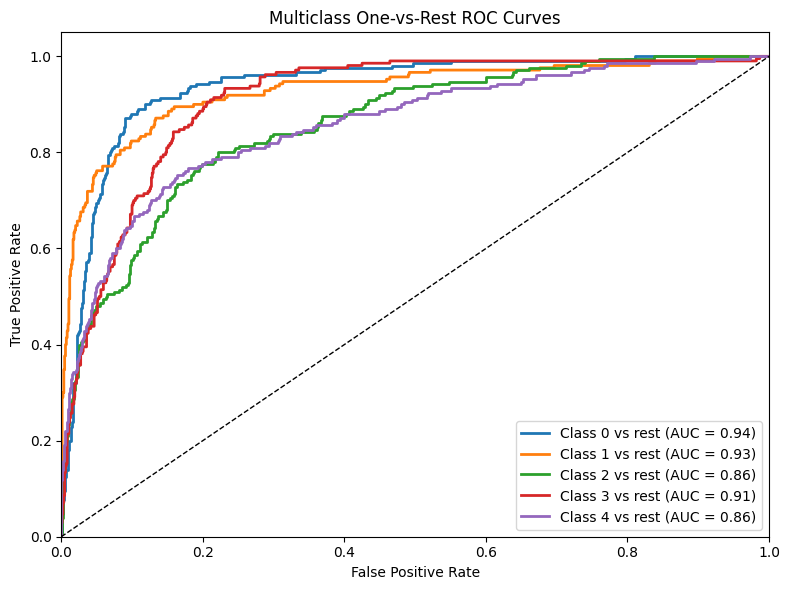

In [ ]:
#--- Plotting a ROC curve for the model ---

# Initializnig list 
all_labels = []
all_probs  = []

# Run predictions
with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs = inputs.cpu()
        logits = model(inputs)                    # shape (B, 5)
        probs  = F.softmax(logits, dim=1).cpu().numpy()  # (B, 5)
        all_probs.append(probs)
        all_labels.append(labels.cpu().numpy()) # changed line

y_true = np.concatenate(all_labels)  # shape (N,)
y_proba = np.concatenate(all_probs)  # shape (N, 5)

# Binarize labels for multiclass one-vs-rest
y_true_bin = label_binarize(y_true, classes=[0,1,2,3,4])  # shape (N,5)

# Compute ROC curve and ROC area for each class
plt.figure(figsize=(8, 6))
for k in range(5):
    fpr, tpr, _ = roc_curve(y_true_bin[:, k], y_proba[:, k])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2,
             label=f'Class {k} vs rest (AUC = {roc_auc:.2f})')

# Plot chance line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass One-vs-Rest ROC Curves')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 4. Linear regression for comparison

In [ ]:
#--- Initializing and running a sample linear regression model ---

# Defining the model
class Linear3DClassifier(nn.Module):
    def __init__(self, in_channels, D, H, W, num_classes=5):
        super().__init__()
        # flatten C×D×H×W → one big vector
        self.fc = nn.Linear(in_channels * D * H * W, num_classes)
    def forward(self, x):
        # x: (B, C, D, H, W)
        B = x.size(0)
        x = x.view(B, -1)          # (B, C*D*H*W)
        return self.fc(x)          # logits (B, num_classes)


# Loading dimensions of data
batch_inputs, batch_labels = next(iter(val_loader))
C, D, H, W = batch_inputs.shape[1:]
model_lin = Linear3DClassifier(C, D, H, W, num_classes=5).to(device)

# Instantiaing the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_lin.parameters(), lr=1e-2, momentum=0.9)

# Training the model
num_epochs = 200
for epoch in range(1, num_epochs+1):
    model_lin.train()
    total_loss = 0
    correct   = 0
    total     = 0

    for inputs, labels in train_loader:   # assumes you have a train_loader
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model_lin(inputs)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total   += inputs.size(0)

    train_loss = total_loss / total
    train_acc  = correct / total

    # Validation
    model_lin.eval()
    val_correct = 0
    val_total   = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model_lin(inputs)
            preds  = logits.argmax(dim=1)
            val_correct += (preds==labels).sum().item()
            val_total   += inputs.size(0)
    val_acc = val_correct / val_total

    print(f"Epoch {epoch:2d}  "
          f"Train Loss: {train_loss:.4f}  "
          f"Train Acc: {train_acc:.3f}  "
          f"Val Acc:   {val_acc:.3f}")


Epoch  1  Train Loss: 1436.0613  Train Acc: 0.235  Val Acc:   0.211
Epoch  2  Train Loss: 1082.5317  Train Acc: 0.256  Val Acc:   0.209
Epoch  3  Train Loss: 1236.9554  Train Acc: 0.268  Val Acc:   0.257
Epoch  4  Train Loss: 1156.7927  Train Acc: 0.278  Val Acc:   0.230
Epoch  5  Train Loss: 1199.5623  Train Acc: 0.284  Val Acc:   0.271
Epoch  6  Train Loss: 1038.1280  Train Acc: 0.294  Val Acc:   0.319
Epoch  7  Train Loss: 1161.1492  Train Acc: 0.283  Val Acc:   0.304
Epoch  8  Train Loss: 1007.9460  Train Acc: 0.297  Val Acc:   0.238
Epoch  9  Train Loss: 1269.2408  Train Acc: 0.296  Val Acc:   0.214
Epoch 10  Train Loss: 1066.1815  Train Acc: 0.301  Val Acc:   0.289
Epoch 11  Train Loss: 1152.3094  Train Acc: 0.302  Val Acc:   0.326
Epoch 12  Train Loss: 1093.4069  Train Acc: 0.306  Val Acc:   0.295
Epoch 13  Train Loss: 1050.0282  Train Acc: 0.317  Val Acc:   0.298
Epoch 14  Train Loss: 969.9400  Train Acc: 0.331  Val Acc:   0.304
Epoch 15  Train Loss: 963.0126  Train Acc: 0.319 

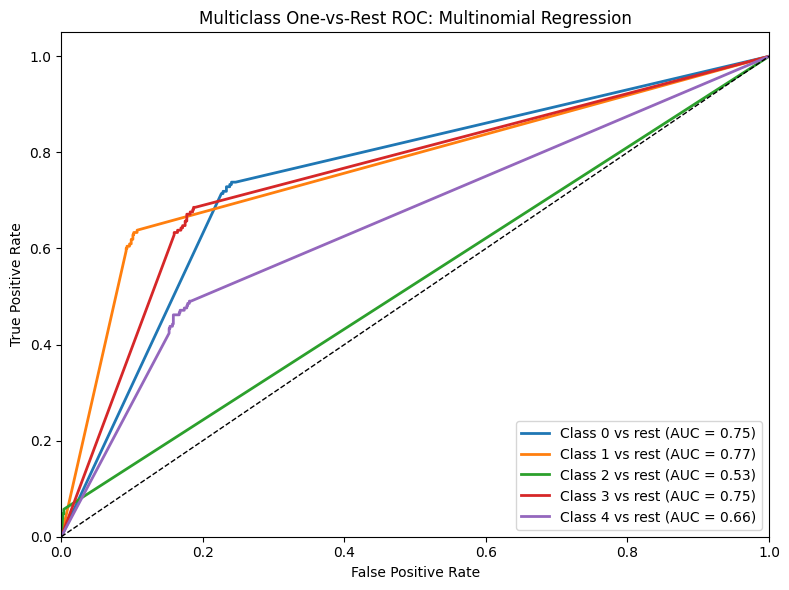

In [ ]:
#--- Plotting a ROC curve for the linear model ---

# Initializing list
all_labels = []
all_probs  = []

# Run predictions
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        logits = model_lin(inputs)                # shape (B, 5)
        probs  = F.softmax(logits, dim=1).cpu().numpy() # (B, 5)
        all_probs.append(probs)
        all_labels.append(labels.cpu().numpy()) 

y_true  = np.concatenate(all_labels)   # shape (N,)
y_proba = np.concatenate(all_probs)    # shape (N, 5)

# Binarize the true labels for one-vs-rest
y_true_bin = label_binarize(y_true, classes=[0,1,2,3,4])  # (N,5)

# Plot one-vs-rest ROC curves
plt.figure(figsize=(8,6))
for k in range(5):
    fpr, tpr, _ = roc_curve(y_true_bin[:, k], y_proba[:, k])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2,
             label=f'Class {k} vs rest (AUC = {roc_auc:.2f})')

# chance line
plt.plot([0,1], [0,1], 'k--', lw=1)

plt.xlim(0,1)
plt.ylim(0,1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass One-vs-Rest ROC: Multinomial Regression')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
